In [1]:
!pip install music21

     |████████████████████████████████| 18.5 MB 9.1 MB/s eta 0:00:01
  Created wheel for music21: filename=music21-5.7.2-py3-none-any.whl size=22024602 sha256=66aaa9dfcdb0e264f77a0213ce2a4187b1329785caad67bfb65696fdacbda3ce
  Stored in directory: /home/meet_himanshu_dutta/.cache/pip/wheels/bc/cb/ae/fd264ebf1e9cf01c15576ee4c128f1bfd907a120c0a7a5b542
Successfully built music21


In [1]:
from music21 import converter, corpus, instrument, midi, note, chord, pitch
import os

In [2]:
midi_path = 'data/audio'

In [3]:
midi_files = os.listdir(midi_path)
len(midi_files)

3924

In [4]:
def open_midi(midi_path, remove_drums):
    # There is an one-line method to read MIDIs
    # but to remove the drums we need to manipulate some
    # low level MIDI events.
    mf = midi.MidiFile()
    mf.open(midi_path)
    mf.read()
    mf.close()
    if (remove_drums):
        for i in range(len(mf.tracks)):
            mf.tracks[i].events = [ev for ev in mf.tracks[i].events if ev.channel != 10]          

    return midi.translate.midiFileToStream(mf)
def list_instruments(midi):
    partStream = midi.parts.stream()
    print("List of instruments found on MIDI file:")
    for p in partStream:
        aux = p
        print (p.partName)

In [5]:
sample = open_midi(os.path.join(midi_path,midi_files[12]),True)

In [6]:
list_instruments(sample)

List of instruments found on MIDI file:
Guitar
None
None
None
Clavichord
None
None
None
None
Electric Bass


In [7]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

def extract_notes(midi_part):
    parent_element = []
    ret = []
    for nt in midi_part.flat.notes:        
        if isinstance(nt, note.Note):
            ret.append(max(0.0, nt.pitch.ps))
            parent_element.append(nt)
        elif isinstance(nt, chord.Chord):
            for pitch in nt.pitches:
                ret.append(max(0.0, pitch.ps))
                parent_element.append(nt)
    
    return ret, parent_element

def print_parts_countour(midi):
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(1, 1, 1)
    minPitch = pitch.Pitch('C10').ps
    maxPitch = 0
    xMax = 0
    
    # Drawing notes.
    for i in range(len(midi.parts)):
        top = midi.parts[i].flat.notes                  
        y, parent_element = extract_notes(top)
        if (len(y) < 1): continue
            
        x = [n.offset for n in parent_element]
        ax.scatter(x, y, alpha=0.6, s=7)
        
        aux = min(y)
        if (aux < minPitch): minPitch = aux
            
        aux = max(y)
        if (aux > maxPitch): maxPitch = aux
            
        aux = max(x)
        if (aux > xMax): xMax = aux
    
    for i in range(1, 10):
        linePitch = pitch.Pitch('C{0}'.format(i)).ps
        if (linePitch > minPitch and linePitch < maxPitch):
            ax.add_line(mlines.Line2D([0, xMax], [linePitch, linePitch], color='red', alpha=0.1))            

    plt.ylabel("Note index (each octave has 12 notes)")
    plt.xlabel("Number of quarter notes (beats)")
    plt.title('Voices motion approximation, each color is a different instrument, red lines show each octave')
    plt.show()

# Focusing only on 6 first measures to make it easier to understand.
# print_parts_countour(sample.measures(0, 6))

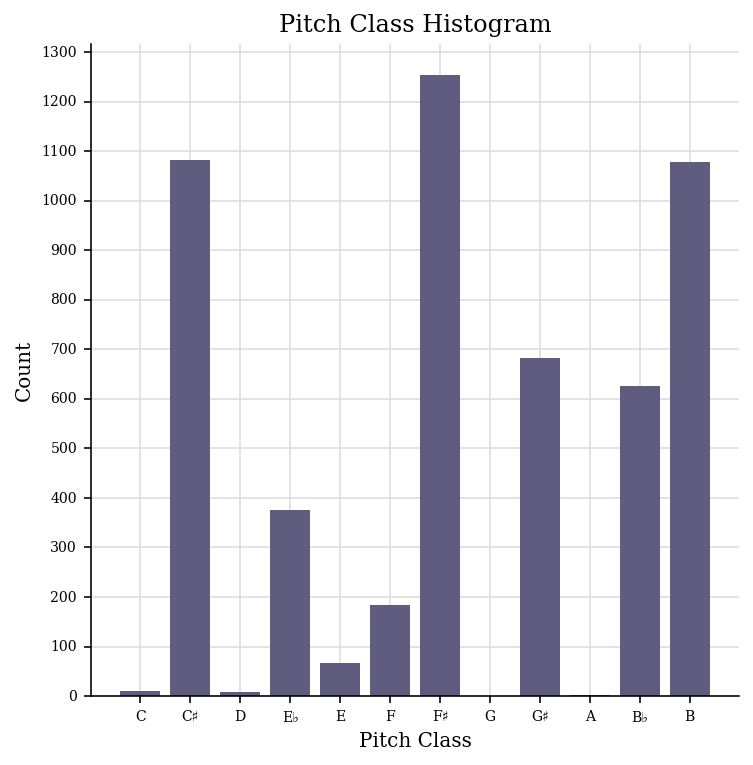

In [8]:
sample.plot('histogram', 'pitchClass', 'count')

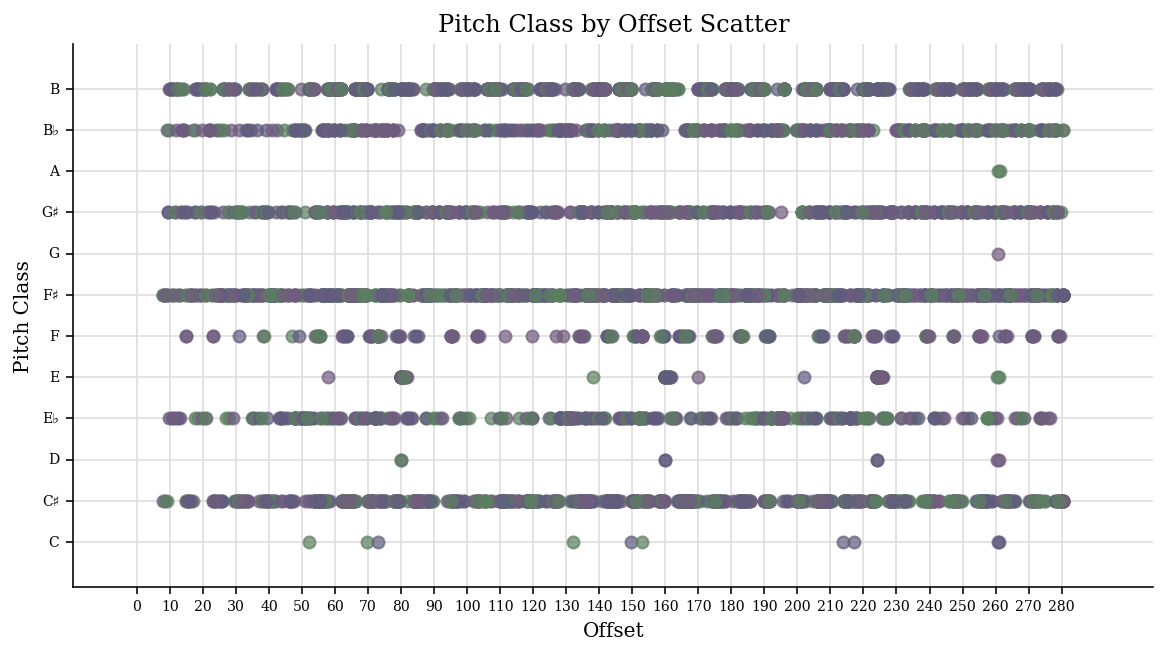

In [9]:
sample.plot('scatter', 'offset', 'pitchClass')

In [8]:
timeSignature = sample.getTimeSignatures()[0]
music_analysis = sample.analyze('key')
print("Music time signature: {0}/{1}".format(timeSignature.beatCount, timeSignature.denominator))
print("Expected music key: {0}".format(music_analysis))
print("Music key confidence: {0}".format(music_analysis.correlationCoefficient))
print("Other music key alternatives:")
for analysis in music_analysis.alternateInterpretations:
    if (analysis.correlationCoefficient > 0.5):
        print(analysis)

Music time signature: 4/4
Expected music key: B major
Music key confidence: 0.8545987603196481
Other music key alternatives:
F# major
f# minor
g# minor
c# minor


In [9]:
from music21 import stream

temp_midi_chords = open_midi(
    os.path.join(midi_path,midi_files[12]),
    True).chordify()
temp_midi = stream.Score()
temp_midi.insert(0, temp_midi_chords)

# Printing merged tracks.
# print_parts_countour(temp_midi)

# Dumping first measure notes
# temp_midi_chords.measures(0, 1).show("text")

In [10]:
from music21 import roman

def note_count(measure, count_dict):
    bass_note = None
    for chord in measure.recurse().getElementsByClass('Chord'):
        # All notes have the same length of its chord parent.
        note_length = chord.quarterLength
        for note in chord.pitches:          
            # If note is "C5", note.name is "C". We use "C5"
            # style to be able to detect more precise inversions.
            note_name = str(note) 
            if (bass_note is None or bass_note.ps > note.ps):
                bass_note = note
                
            if note_name in count_dict:
                count_dict[note_name] += note_length
            else:
                count_dict[note_name] = note_length
        
    return bass_note
                
def simplify_roman_name(roman_numeral):
    # Chords can get nasty names as "bII#86#6#5",
    # in this method we try to simplify names, even if it ends in
    # a different chord to reduce the chord vocabulary and display
    # chord function clearer.
    ret = roman_numeral.romanNumeral
    inversion_name = None
    inversion = roman_numeral.inversion()
    
    # Checking valid inversions.
    if ((roman_numeral.isTriad() and inversion < 3) or
            (inversion < 4 and
                 (roman_numeral.seventh is not None or roman_numeral.isSeventh()))):
        inversion_name = roman_numeral.inversionName()
        
    if (inversion_name is not None):
        ret = ret + str(inversion_name)
        
    elif (roman_numeral.isDominantSeventh()): ret = ret + "M7"
    elif (roman_numeral.isDiminishedSeventh()): ret = ret + "o7"
    return ret
                
def harmonic_reduction(midi_file):
    ret = []
    temp_midi = stream.Score()
    temp_midi_chords = midi_file.chordify()
    temp_midi.insert(0, temp_midi_chords)    
    music_key = temp_midi.analyze('key')
    max_notes_per_chord = 4   
    for m in temp_midi_chords.measures(0, None): # None = get all measures.
        if (type(m) != stream.Measure):
            continue
        
        # Here we count all notes length in each measure,
        # get the most frequent ones and try to create a chord with them.
        count_dict = dict()
        bass_note = note_count(m, count_dict)
        if (len(count_dict) < 1):
            ret.append("-") # Empty measure
            continue
        
        sorted_items = sorted(count_dict.items(), key=lambda x:x[1])
        sorted_notes = [item[0] for item in sorted_items[-max_notes_per_chord:]]
        measure_chord = chord.Chord(sorted_notes)
        
        # Convert the chord to the functional roman representation
        # to make its information independent of the music key.
        roman_numeral = roman.romanNumeralFromChord(measure_chord, music_key)
        ret.append(simplify_roman_name(roman_numeral))
        
    return ret

harmonic_reduction(sample)[0:10]

['-', '-', '--vii', '--vii', 'iv', '--vii', 'i', 'ii65', 'i', 'ii65']

In [10]:
hr_sample = harmonic_reduction(sample)

In [11]:
hr_list = []
count = 0

In [12]:
def midi_reduction(midi):
    global count
    name = midi[:-4]
    sample = open_midi(os.path.join(midi_path,midi),True)
    hr_sample = harmonic_reduction(sample)
    hr_list.append([name,hr_sample])
    count += 1
    if count%10==0:
        print(f'processed {count}/{len(midi_files)} files...')
        hr_df = pd.DataFrame(hr_list,columns=['id','harmoinc_reduction']).set_index('id')
        hr_df.to_csv('hr_df.csv')

In [13]:
import multiprocessing
import pandas as pd
pool = multiprocessing.Pool() 
pool = multiprocessing.Pool(processes=6)
pool.map(midi_reduction, midi_files)

processed 10/3924 files...
processed 10/3924 files...
processed 10/3924 files...
processed 20/3924 files...
processed 10/3924 files...
processed 10/3924 files...
processed 20/3924 files...
processed 10/3924 files...
processed 20/3924 files...
processed 30/3924 files...
processed 20/3924 files...
processed 30/3924 files...
processed 20/3924 files...
processed 30/3924 files...
processed 20/3924 files...
processed 40/3924 files...
processed 30/3924 files...
processed 30/3924 files...
processed 40/3924 files...
processed 40/3924 files...
processed 50/3924 files...
processed 40/3924 files...
processed 30/3924 files...
processed 40/3924 files...
processed 50/3924 files...
processed 40/3924 files...
processed 60/3924 files...
processed 50/3924 files...
processed 50/3924 files...
processed 50/3924 files...
processed 60/3924 files...
processed 70/3924 files...
processed 60/3924 files...


Process ForkPoolWorker-9:
Process ForkPoolWorker-1:
Process ForkPoolWorker-12:
Process ForkPoolWorker-3:
Process ForkPoolWorker-7:
Process ForkPoolWorker-5:
Process ForkPoolWorker-11:
Process ForkPoolWorker-14:
Process ForkPoolWorker-10:
Process ForkPoolWorker-4:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-6:
Traceback (most recent call last):
Process ForkPoolWorker-8:
Process ForkPoolWorker-2:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/meet_himanshu_dutta/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/meet_himanshu_dutta/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/meet_himanshu_dutta/anaconda3/lib/python3.

KeyboardInterrupt: 

Process ForkPoolWorker-13:
Traceback (most recent call last):
  File "/home/meet_himanshu_dutta/anaconda3/lib/python3.7/site-packages/music21/common/classTools.py", line 52, in isNum
    dummy = usrData + 0
TypeError: can only concatenate str (not "int") to str

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/meet_himanshu_dutta/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/meet_himanshu_dutta/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/meet_himanshu_dutta/anaconda3/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/meet_himanshu_dutta/anaconda3/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "<ipython-input-12-16959cc20651>", line 5, in midi_reduction
    hr_sample

In [13]:

# hr_df = pd.DataFrame(hr_list,columns=['id','harmoinc_reduction']).set_index('id')
# hr_df.to_csv('hr_df.csv')

In [20]:
hr_list, count

([], 0)